In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import arff
import matplotlib.pyplot as plt
from scripts.experiment_functions import kfold_experiments

# Read Data

Churn data

In [2]:
churn_data = arff.loadarff("data/chrun.arff")
churn_df = pd.DataFrame(churn_data[0])

Ok Cupid data

In [3]:
okcupid_stem = arff.loadarff("data/okcupid_stem.arff")
okcupid_df = pd.DataFrame(okcupid_stem[0])

### Small pre-processing. 

The columns **class** and **number_customer_service_calls** can be made ints

In [3]:
churn_df["class"] = churn_df["class"].astype(int)
churn_df["number_customer_service_calls"] = churn_df["number_customer_service_calls"].astype(int)

We replace **'?'** with nan values.
The income column is turned to float values

In [5]:
def determine_dtype(x):
    return x.decode("utf-8")
    

okcupid_df["job"] = okcupid_df["job"].apply(determine_dtype)

In [6]:
okcupid_df.replace(b'?', np.nan, inplace=True)
okcupid_df["income"] = okcupid_df["income"].astype('float64')

# Experiments

### Churn data experiments

Prepare parameters

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [5]:
# Data
X_churn = churn_df.drop(columns="class")
y_churn = np.reshape(churn_df["class"].values, X_churn.shape[0])

# Experiment parameters
kfolds = 5
scorer = "neg_log_loss"
ncores = 50
random_state = 42

# AutoML params
automl_dict = {"classification_algorithms": ["EL", "RF", "GB"],
               "numerical_strategies": ["SSE", "MMS"],
               "categorical_strategies": ["OHE", "SUM"],
               "test_fraction": 0.1,
               "cv_folds": 4,
               "random_state": random_state,
               "num_iterations": 1,
               "fidelity_parameter": 3,
               "n_jobs": ncores,
               "loss_function": scorer,
               "optimizer_strategy": "hyperband"}

# Voters
voter_clfs = [RandomForestClassifier(random_state=random_state), 
              DecisionTreeClassifier(random_state=random_state),
              GradientBoostingClassifier(random_state=random_state)]

In [6]:
churn_experiment, churn_automl = kfold_experiments(X_churn, y_churn, kfolds, scorer, automl_dict, voter_clfs,
                                                  n_cores=ncores, random_state=42)

Fold 0


Data-Model combinations: 0it [00:00, ?it/s]

{'C': 0.990055496341547, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9936813836200534, 'max_iter': 492, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7822866725012269, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.27485731538470026, 'max_iter': 758, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.6910810048799055, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.3608392506404452, 'max_iter': 340, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.5872171492820513, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8552457179626585, 'max_iter': 495, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/

{'C': 0.13421671672854496, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.4517457064305477, 'max_iter': 58, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.23733228791298489, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8764603658976323, 'max_iter': 644, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.22533400125365255, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.04748889147488344, 'max_iter': 36, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.17190298735450038, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.6329674866364626, 'max_iter': 86, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.30112437864126607, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5133046436725569, 'max_iter': 135, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.8277229297111276, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.34670864263673395, 'max_iter': 35, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.9672965590675915, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5655464323267194, 'max_iter': 360, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.5150173686937395, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.6570862766361216, 'max_iter': 596, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.3861645902730839, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.1973640347372576, 'max_iter': 243, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.017417717626613483, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9425454302013605, 'max_iter': 672, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.07233736627815579, 'class_weight': None, 'dual': False, 'fit

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7450547467591022, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.6171342469497346, 'max_iter': 897, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.2860704843350428, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.7833253722479198, 'max_iter': 620, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.6002340728718512, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.7970173866620199, 'max_iter': 437, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7463112645877681, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.41819484580125166, 'max_iter': 206, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.43832739561931733, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.31121235377701983, 'max_iter': 802, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.20849744276740168, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.837931796616951, 'max_iter': 477, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.040932080853689934, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.4968666020600272, 'max_iter': 415, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.9040869333568093, 'class_weight': None, 'dual': False, 'fi

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.2473161344167052, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.848954217417198, 'max_iter': 395, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.5523757558460847, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5062817224871244, 'max_iter': 820, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.3456352780590435, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9376446859291614, 'max_iter': 677, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.15584632394582465, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.16345065049098573, 'max_iter': 883, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.9232289037640545, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.46245029459834575, 'max_iter': 505, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.38673671010200716, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8804136482061405, 'max_iter': 790, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.5774235452609554, 'class_weight': None, 'dual': False, 'fi

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.3224772906514386, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.13945147167742655, 'max_iter': 77, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7950924903749698, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.7607874247418128, 'max_iter': 643, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.967792649916248, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.16829969336259676, 'max_iter': 768, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.42238309066559, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.4250743646341357, 'max_iter': 227, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7668771857343255, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9817271127758073, 'max_iter': 183, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/

{'C': 0.402130813579627, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5505914962162585, 'max_iter': 10, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.95703828554005, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9684823002111332, 'max_iter': 717, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/

{'C': 0.2345145063594527, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.49615428915971227, 'max_iter': 54, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7773943888838697, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.2560151886893757, 'max_iter': 629, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.8257512061714317, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.015907159141213323, 'max_iter': 427, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.16056705034293728, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.28299501192351373, 'max_iter': 538, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.1420715366523274, 'class_weight': None, 'dual': False, 'fi

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.1778446214979117, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5876417339777913, 'max_iter': 271, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.4521174605176277, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5794824913040038, 'max_iter': 570, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.28780880427546185, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.80669522474936, 'max_iter': 704, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.44217878612882866, 'class_weight': None, 'dual': False, 'fit_in

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.23967459900196086, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5847356201889542, 'max_iter': 766, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.02374043205281251, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.993850976894572, 'max_iter': 300, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.5658451127968074, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.4123673844068132, 'max_iter': 531, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.7804615275804557, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9198950663618332, 'max_iter': 649, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.34344916346360077, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8297060111696632, 'max_iter': 497, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.4691971286420925, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.1500733961744506, 'max_iter': 973, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.467990747095402, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.3814300010222703, 'max_iter': 866, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.6126316773899818, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9257693236739123, 'max_iter': 676, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.09180182191084985, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.45018193421038966, 'max_iter': 579, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.00048596379421350644, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.30202056806103017, 'max_iter': 901, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.8649641955668915, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.022349733263960836, 'max_iter': 685, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.019103116452746538, 'class_weight': None, 'dual': Fal

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.09103115516200555, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9531187002973224, 'max_iter': 215, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.42276470325156934, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8694783246146448, 'max_iter': 780, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.5867657224160497, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8393860279078784, 'max_iter': 260, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.34102411306231517, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9112628459706993, 'max_iter': 495, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.12292983481794795, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.09988140966742132, 'max_iter': 946, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.11254410206962251, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8601406158015263, 'max_iter': 783, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.9344200610291898, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8018185126043997, 'max_iter': 890, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.2324475992550411, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.429159239577493, 'max_iter': 888, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.8465246628392539, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.6116918020133123, 'max_iter': 749, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.36261590507405295, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.959606420598738, 'max_iter': 554, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.42459994702325965, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.6377952791649238, 'max_iter': 826, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.785065230865117, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.546946092971564, 'max_iter': 180, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/

{'C': 0.9881913071142017, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.7587550918910845, 'max_iter': 83, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.3970583815864138, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.21943582076418278, 'max_iter': 511, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.990055496341547, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9936813836200534, 'max_iter': 492, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7822866725012269, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.27485731538470026, 'max_iter': 758, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.6910810048799055, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.3608392506404452, 'max_iter': 340, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.8277229297111276, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.34670864263673395, 'max_iter': 35, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.9672965590675915, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5655464323267194, 'max_iter': 360, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7450547467591022, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.6171342469497346, 'max_iter': 897, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.7463112645877681, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.41819484580125166, 'max_iter': 206, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.9040869333568093, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.7841753960387393, 'max_iter': 699, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.3456352780590435, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9376446859291614, 'max_iter': 677, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.9232289037640545, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.46245029459834575, 'max_iter': 505, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.38673671010200716, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8804136482061405, 'max_iter': 790, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.7950924903749698, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.7607874247418128, 'max_iter': 643, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.967792649916248, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.16829969336259676, 'max_iter': 768, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.95703828554005, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9684823002111332, 'max_iter': 717, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7773943888838697, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.2560151886893757, 'max_iter': 629, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.8257512061714317, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.015907159141213323, 'max_iter': 427, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.6543509943135384, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.39836817361081844, 'max_iter': 211, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.44217878612882866, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.901871072975272, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.9035348524993363, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.544302045875725, 'max_iter': 366, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.34344916346360077, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8297060111696632, 'max_iter': 497, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.8649641955668915, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.022349733263960836, 'max_iter': 685, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.34102411306231517, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9112628459706993, 'max_iter': 495, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.9344200610291898, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8018185126043997, 'max_iter': 890, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.8465246628392539, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.6116918020133123, 'max_iter': 749, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.36261590507405295, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.959606420598738, 'max_iter': 554, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.785065230865117, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.546946092971564, 'max_iter': 180, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/

{'C': 0.9881913071142017, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.7587550918910845, 'max_iter': 83, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.990055496341547, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9936813836200534, 'max_iter': 492, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.9672965590675915, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5655464323267194, 'max_iter': 360, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.9232289037640545, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.46245029459834575, 'max_iter': 505, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.967792649916248, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.16829969336259676, 'max_iter': 768, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.8257512061714317, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.015907159141213323, 'max_iter': 427, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.9035348524993363, 'class_weight': None, 'dual': False, 'fit

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.8649641955668915, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.022349733263960836, 'max_iter': 685, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.9344200610291898, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8018185126043997, 'max_iter': 890, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.9881913071142017, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.7587550918910845, 'max_iter': 83, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.9672965590675915, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5655464323267194, 'max_iter': 360, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.9232289037640545, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.46245029459834575, 'max_iter': 505, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.967792649916248, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.16829969336259676, 'max_iter': 768, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.967792649916248, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.16829969336259676, 'max_iter': 768, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
[{'fit_failed': False, 'test_scores': {'score': -0.31522703913676126}

Data-Model combinations: 1it [03:42, 222.37s/it]

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.5903142475470926, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 90, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.5523218916937532, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 66, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes'

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.955650035534739, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 28, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.12456594484112049, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 39, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_node

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.13934198303879652, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 29, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.3056755388993262, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 86, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.28453389849768695, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 89, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.24647959124225072, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 40, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 1, 'max_features': 'auto', 'max_leaf_nod

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.5991934542169767, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 22, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.17750094969539776, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 77, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes':

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.4338328976794984, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 13, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.340196165901252, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 28, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': 

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.19393488284894045, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 91, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.7217017524999066, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 94, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
[{'fit_failed': False, 'test_scores': {'score': -0.20737589594744482}, 'n_test_samples': 900, 'fit_time': 0.3284940719604492, 'score_t

Data-Model combinations: 2it [05:54, 169.45s/it]

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.10219856975263597, 'loss': 'deviance', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 56, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.38905437457005676, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.8689497579295653, 'loss': 'deviance', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.3393396902900533, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.39717484886934784, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 17, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.37517343073519394, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.2949162779314667, 'loss': 'deviance', 'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 21, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.2945131532905735, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.6428452825415581, 'loss': 'deviance', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 93, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.1854355809110167, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.9857427161384971, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 83, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.2594695072477068, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'cc

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.3643568311647214, 'loss': 'deviance', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 71, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.3948279917869182, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.7450198313038959, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.25219278024427544, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.5840413013981647, 'loss': 'deviance', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 82, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.15225224036470528, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.9223454041110417, 'loss': 'deviance', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 69, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.20245302551846175, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1827433875968515, 'loss': 'deviance', 'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 17, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.3762997382577432, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.5183616886581898, 'loss': 'deviance', 'max_depth': 1, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 9, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.3221871457750156, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.010730935592465962, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 37, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.4323741504135912, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05606593409002003, 'loss': 'deviance', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 2, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.1165073248817397, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.02859280418272192, 'loss': 'deviance', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 87, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.2497813600511849, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
[{'fit_failed': False, 'test_scores': {'score': -0.1939375227654012}, 'n_test_samples': 900, 'fit_time': 0.5051755905151367, 'score_time': 0.0027391910552978516}, {'fit_failed': False, 'test_scores': {'score': -0.1335511362581558}, 'n_test_samples': 900, 'fit_time': 0.5076184272766113, 'score_time': 0.003887653350830078}, {'fit_failed': False, 'test_scores': {'score': -0.19073937000817537}, 'n_test_samples': 900, 'fit_time': 0.5824322700500488, 'score_time': 0.0029621124267578125}, {'fit_failed':

Data-Model combinations: 3it [08:30, 163.17s/it]

{'C': 0.990055496341547, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9936813836200534, 'max_iter': 492, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7822866725012269, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.27485731538470026, 'max_iter': 758, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.6910810048799055, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.3608392506404452, 'max_iter': 340, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.5872171492820513, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8552457179626585, 'max_iter': 495, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.13421671672854496, 'class_weight': None, 'dual': False, 'fit_

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.17190298735450038, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.6329674866364626, 'max_iter': 86, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.30112437864126607, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5133046436725569, 'max_iter': 135, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.8277229297111276, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.34670864263673395, 'max_iter': 35, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.9672965590675915, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5655464323267194, 'max_iter': 360, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.5150173686937395, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.6570862766361216, 'max_iter': 596, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.3861645902730839, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.1973640347372576, 'max_iter': 243, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.017417717626613483, 'class_weight': None, 'dual': False, 'fit_

{'C': 0.42238309066559, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.4250743646341357, 'max_iter': 227, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.7668771857343255, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9817271127758073, 'max_iter': 183, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/

{'C': 0.402130813579627, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5505914962162585, 'max_iter': 10, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.95703828554005, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9684823002111332, 'max_iter': 717, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.2345145063594527, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.49615428915971227, 'max_iter': 54, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7773943888838697, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.2560151886893757, 'max_iter': 629, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.8257512061714317, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.015907159141213323, 'max_iter': 427, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.16056705034293728, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.28299501192351373, 'max_iter': 538, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.1420715366523274, 'class_weight': None, 'dual': False, 'fi

{'C': 0.5867657224160497, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8393860279078784, 'max_iter': 260, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.34102411306231517, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9112628459706993, 'max_iter': 495, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.12292983481794795, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.09988140966742132, 'max_iter': 946, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.11254410206962251, 'class_weight': None, 'dual': False, 'fi

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.3970583815864138, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.21943582076418278, 'max_iter': 511, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.990055496341547, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9936813836200534, 'max_iter': 492, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7822866725012269, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.27485731538470026, 'max_iter': 758, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.6910810048799055, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.3608392506404452, 'max_iter': 340, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.5872171492820513, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8552457179626585, 'max_iter': 495, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.8277229297111276, 'class_weight': None, 'dual': False, 'fit_i

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.9672965590675915, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5655464323267194, 'max_iter': 360, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.7450547467591022, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.6171342469497346, 'max_iter': 897, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.6002340728718512, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.7970173866620199, 'max_iter': 437, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.7463112645877681, 'class_weight': None, 'dual': False, 'fit_in

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.95703828554005, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9684823002111332, 'max_iter': 717, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.7773943888838697, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.2560151886893757, 'max_iter': 629, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.8257512061714317, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.015907159141213323, 'max_iter': 427, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.9035348524993363, 'class_weight': None, 'dual': False, 'fit_in

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.990055496341547, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9936813836200534, 'max_iter': 492, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.9672965590675915, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5655464323267194, 'max_iter': 360, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.9040869333568093, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.7841753960387393, 'max_iter': 699, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.7950924903749698, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.7607874247418128, 'max_iter': 643, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.7668771857343255, 'class_weight': None, 'dual': False, 'fit_in

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.95703828554005, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9684823002111332, 'max_iter': 717, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.7804615275804557, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9198950663618332, 'max_iter': 649, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.9344200610291898, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8018185126043997, 'max_iter': 890, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.9881913071142017, 'class_weight': None, 'dual': False, 'fit_inte

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.990055496341547, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9936813836200534, 'max_iter': 492, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7668771857343255, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9817271127758073, 'max_iter': 183, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.95703828554005, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9684823002111332, 'max_iter': 717, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.990055496341547, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9936813836200534, 'max_iter': 492, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[{'fit_failed': False, 'test_scores': {'score': -0.31535469112350206}, 'n_test_samples': 900, 'fit_time': 0.5696749687194824, 'score_time': 0.017278671264648438}, {'fit_failed': False, 'test_scores': {'score': -0.3023518434844631}, 'n_test_samples': 900, 'fit_time': 0.6296646595001221, 'score_time': 0.007295370101928711}, {'fit_failed': False, 'test_scores': {'score': -0.3267685867978696}, 'n_test_samples': 900, 'fit_time': 0.6224353313446045, 'score_time': 0.009296178817749023}, {'fit_failed': False, 'test_scores': {'score': -0.3224701551697618}, 'n_test_samples': 900, 'fit_time': 0.6013076305389404, 'score_time': 0.0607452392578125}, {'fit_failed': False, 'test_scores': {'score': -0.3153546912641859}, 'n_test_samples': 900, 'fit_time': 0.592731237411499, 'score_time': 0.01408243179321289}, {'fit_failed': False, 'test_scores': {'score': -0.3023518444989999}, 'n_test_samples': 900, 'fit_time': 0.593280553817749, 'score_time': 0.010058403015136719}, {'fit_failed': False, 'test_scores': 

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Data-Model combinations: 4it [10:22, 142.97s/it]

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.5903142475470926, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 90, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.5523218916937532, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 66, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes'

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.955650035534739, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 28, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.12456594484112049, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 39, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_node

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.13934198303879652, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 29, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.3056755388993262, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 86, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.28453389849768695, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 89, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.24647959124225072, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 40, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 1, 'max_features': 'auto', 'max_leaf_nod

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.5991934542169767, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 22, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.17750094969539776, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 77, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes':

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.4338328976794984, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 13, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.340196165901252, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 28, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': 

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.19393488284894045, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 91, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.7217017524999066, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 94, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
[{'fit_failed': False, 'test_scores': {'score': -0.2070167592233228}, 'n_test_samples': 900, 'fit_time': 0.3260917663574219, 'score_ti

Data-Model combinations: 5it [12:31, 137.87s/it]

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.10219856975263597, 'loss': 'deviance', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 56, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.38905437457005676, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.8689497579295653, 'loss': 'deviance', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.3393396902900533, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.39717484886934784, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 17, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.37517343073519394, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.2949162779314667, 'loss': 'deviance', 'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 21, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.2945131532905735, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.6428452825415581, 'loss': 'deviance', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 93, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.1854355809110167, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.9857427161384971, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 83, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.2594695072477068, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'cc

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.3643568311647214, 'loss': 'deviance', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 71, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.3948279917869182, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.7450198313038959, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.25219278024427544, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.5840413013981647, 'loss': 'deviance', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 82, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.15225224036470528, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.9223454041110417, 'loss': 'deviance', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 69, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.20245302551846175, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.334080643356078, 'loss': 'deviance', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 86, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.42988278110917333, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1827433875968515, 'loss': 'deviance', 'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 17, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.3762997382577432, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'cc

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.010730935592465962, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 37, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.4323741504135912, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05606593409002003, 'loss': 'deviance', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 2, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.1165073248817397, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'

[{'fit_failed': False, 'test_scores': {'score': -0.16447770784916946}, 'n_test_samples': 900, 'fit_time': 0.4497196674346924, 'score_time': 0.002228260040283203}, {'fit_failed': False, 'test_scores': {'score': -0.14082993163888732}, 'n_test_samples': 900, 'fit_time': 0.44440245628356934, 'score_time': 0.0019850730895996094}, {'fit_failed': False, 'test_scores': {'score': -0.19186873371224641}, 'n_test_samples': 900, 'fit_time': 0.45119214057922363, 'score_time': 0.0020465850830078125}, {'fit_failed': False, 'test_scores': {'score': -0.18870610994555492}, 'n_test_samples': 900, 'fit_time': 0.4525260925292969, 'score_time': 0.002010345458984375}, {'fit_failed': False, 'test_scores': {'score': -0.1658168604329115}, 'n_test_samples': 900, 'fit_time': 0.44434618949890137, 'score_time': 0.0022203922271728516}, {'fit_failed': False, 'test_scores': {'score': -0.14543407691017352}, 'n_test_samples': 900, 'fit_time': 0.4437081813812256, 'score_time': 0.002003908157348633}, {'fit_failed': False, 

Data-Model combinations: 6it [14:50, 138.21s/it]

{'C': 0.990055496341547, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9936813836200534, 'max_iter': 492, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7822866725012269, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.27485731538470026, 'max_iter': 758, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.6910810048799055, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.3608392506404452, 'max_iter': 340, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.5872171492820513, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.8552457179626585, 'max_iter': 495, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.13421671672854496, 'class_weight': None, 'dual': False, 'fit_

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.30112437864126607, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5133046436725569, 'max_iter': 135, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.8277229297111276, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.34670864263673395, 'max_iter': 35, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.9672965590675915, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5655464323267194, 'max_iter': 360, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.5150173686937395, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.6570862766361216, 'max_iter': 596, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.3861645902730839, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.1973640347372576, 'max_iter': 243, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.017417717626613483, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9425454302013605, 'max_iter': 672, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.07233736627815579, 'class_weight': None, 'dual': False, 'fit

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.7950924903749698, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.7607874247418128, 'max_iter': 643, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.967792649916248, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.16829969336259676, 'max_iter': 768, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.42238309066559, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.4250743646341357, 'max_iter': 227, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.7668771857343255, 'class_weight': None, 'dual': False, 'fit_inte

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.402130813579627, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5505914962162585, 'max_iter': 10, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.95703828554005, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.9684823002111332, 'max_iter': 717, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/roberto_olayo/miniconda3/envs/

{'C': 0.2345145063594527, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.49615428915971227, 'max_iter': 54, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.7773943888838697, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.2560151886893757, 'max_iter': 629, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.8257512061714317, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.015907159141213323, 'max_iter': 427, 'multi_class': 'auto', 'n_jobs': 1, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 0.16056705034293728, 'class_weight': None, 'dual': False, 'fit

Data-Model combinations: 6it [15:19, 153.29s/it]


KeyboardInterrupt: 

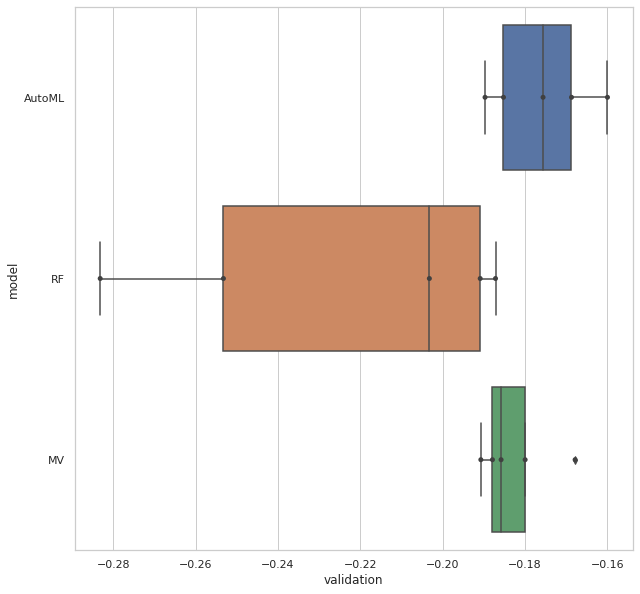

In [10]:
plt.figure(figsize=(10,10))
sns.set_theme(style="whitegrid")
# plot boxplot
bp = sns.boxplot(x="validation", y="model", data=churn_experiment)
bp = sns.swarmplot(x="validation", y="model", data=churn_experiment, color=".25")
bp.get_figure().savefig("data/churn_results/base_boxplot.pdf", bbox_inches='tight')

In [11]:
churn_experiment.to_csv("data/churn_experiments.tsv.gz", sep='\t')
churn_automl.to_csv("data/churn_automl.tsv.gz", sep='\t')

In [14]:
churn_automl.columns

Index(['iter', 'n_resources', 'mean_fit_time', 'std_fit_time',
       'mean_score_time', 'std_score_time', 'param_C', 'param_l1_ratio',
       'param_max_iter', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'mean_train_score', 'std_train_score', 'hyperband_iter', 'combination',
       'param_bootstrap', 'param_criterion', 'param_max_depth',
       'param_max_samples', 'param_n_estimators', 'param_learning_rate',
       'param_subsample', 'champion', 'kfold'],
      dtype='object')

In [69]:
xdf = churn_automl.loc[(churn_automl["champion"] == "champion") & (churn_automl["hyperband_iter"] == 0),
             ["iter", "mean_test_score"]]

In [70]:
mean_iter = xdf.groupby("iter")["mean_test_score"].mean()

In [71]:
std_iter = xdf.groupby("iter")["mean_test_score"].std()

In [72]:
x = mean_iter.index

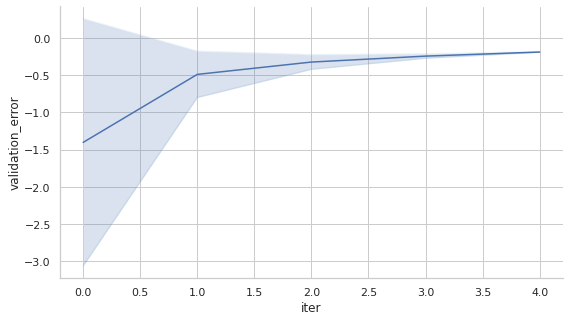

In [74]:
# Compute upper and lower bounds using chosen uncertainty measure: here
# it is a fraction of the standard deviation of measurements at each
# time point based on the unbiased sample variance
lower = mean_iter - std_iter
upper = mean_iter + std_iter

# Draw plot with error band and extra formatting to match seaborn style
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x, mean_iter, label='signal mean')
ax.plot(x, lower, color='tab:blue', alpha=0.1)
ax.plot(x, upper, color='tab:blue', alpha=0.1)
ax.fill_between(x, lower, upper, alpha=0.2)
ax.set_xlabel('iter')
ax.set_ylabel('validation_error')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [76]:
ax.get_figure().savefig("data/test.pdf", bbox_inches="tight")

In [53]:
jeje=xdf[["iter", "mean_test_score"]].drop_duplicates()

In [55]:
jeje

,iter,mean_test_score
0,0,-1.966284
1,0,-2.965653
2,0,-0.746925
3,0,-0.327636
4,0,-0.957811
...,...,...
26,2,-0.280345
27,2,-0.252690
28,3,-0.237237
29,3,-0.221183


ValueError: cannot reindex from a duplicate axis

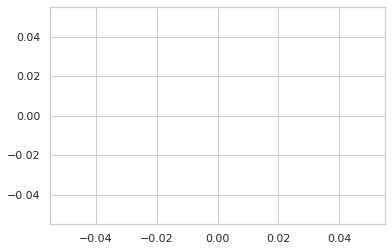

In [54]:
sns.lineplot(x="iter", y="mean_test_score", data=jeje)

ValueError: cannot reindex from a duplicate axis

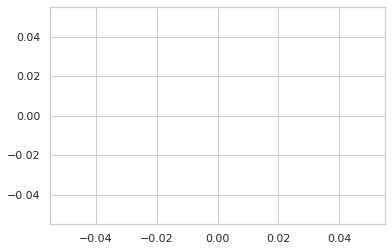

In [44]:
sns.lineplot(x="iter", y="mean_test_score", data=xdf, units="kfold")

Okcupid experiments

In [8]:
# Data
X_cupid = okcupid_df.drop(columns="job")
y_cupid = np.reshape(okcupid_df["job"].values, X_cupid.shape[0])

In [9]:
X_cupid.shape

(50789, 19)

In [10]:
# Experiment parameters
kfolds = 10
scorer = "neg_log_loss"
ncores = 80
random_state = 42

# AutoML params
automl_dict = {"classification_algorithms": ["DT", "RF", "GB"],
               "numerical_strategies": ["SSE", "MMS"],
               "categorical_strategies": ["OHE", "SUM"],
               "test_fraction": 0.3,
               "cv_folds": 3,
               "random_state": random_state,
               "num_iterations": 4,
               "fidelity_parameter": 4,
               "n_jobs": ncores,
               "loss_function": scorer,
               "n_estimators": 10}

# Voters
voter_clfs = [RandomForestClassifier(random_state=random_state), 
              DecisionTreeClassifier(random_state=random_state),
              GradientBoostingClassifier(random_state=random_state)]

In [11]:
cupid_experiment, cupid_automl = kfold_experiments(X_cupid, y_cupid, kfolds, scorer, automl_dict, voter_clfs,
                                                  n_cores=ncores, random_state=42)

Fold 0


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations:   0%|          | 0/4 [00:00<?, ?it/s]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan -4.24381955 -3.13221726
 -2.71329363]
  category=UserWarning

Hyperband iterations: 100%|██████████| 4/4 [00:30<00:00,  7.52s/it]
Data-Model combinations: 1it [00:30, 30.09s/it]
Hyperband iterations:   0%|          | 0/4 [00:00<?, ?it/s]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or 

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  -2.56594334  -0.7778307  -20.87584678]
  category=UserWarning

Hyperband iterations: 100%|██████████| 4/4 [03:40<00:00, 55.19s/it]
Data-Model combinations: 9it [14:06, 115.32s/it]
Hyperband iterations:   0%|          | 0/4 [00:00<?, ?it/s]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan 

Fold 1


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations:   0%|          | 0/4 [00:00<?, ?it/s]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan -6.1739257 -4.4939458
 -3.1794911]
  category=UserWarning

Hyperband iterations: 100%|██████████| 4/4 [00:32<00:00,  8.04s/it]
Data-Model combinations: 1it [00:32, 32.16s/it]
Hyperband iterations:   0%|          | 0/4 [00:00<?, ?it/s]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the t

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  -2.31066429  -0.75724017 -20.94520175]
  category=UserWarning

Hyperband iterations: 100%|██████████| 4/4 [03:39<00:00, 54.86s/it]
Data-Model combinations: 9it [14:10, 115.27s/it]
Hyperband iterations:   0%|          | 0/4 [00:00<?, ?it/s]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan 

KeyboardInterrupt: 

In [ ]:
cupid_experiment.to_csv("data/cupid_experiment.tsv.gz", sep='\t')
cupid_automl.to_csv("data/cupid_experiment.tsv.gz", sep='\t')